## ゲート付きRNN
* 前回のRNNはそこまで性能はよくない
* 原因として長期の依存関係をうまく学習することができていないため。
* 一般的にRNNはLSTMであることが多い

### RNNの問題点
* BPTTにおいて勾配消失と勾配爆発が生じる

### 勾配消失と勾配爆発の原因
* tanh関数を微分した式は1.0以下の値であり、勾配がtanhノードを通るたびにその値が小さくなる。
* "https://arxiv.org/abs/1511.03771" ,ではrelu関数を使用して勾配消失を抑えている。

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
os.chdir("./deep-learning-from-scratch-2-master")

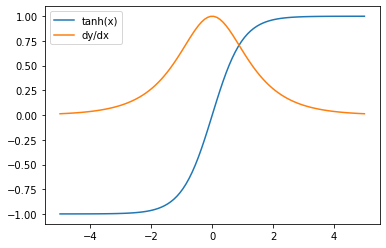

In [2]:
x = np.linspace(-5, 5, 100)
y = np.tanh(x)
plt.plot(x, y, label="tanh(x)")

x = np.linspace(-5, 5, 100)
y = 1 / np.cosh(x)
plt.plot(x, y, label="dy/dx")
plt.legend()
plt.show()

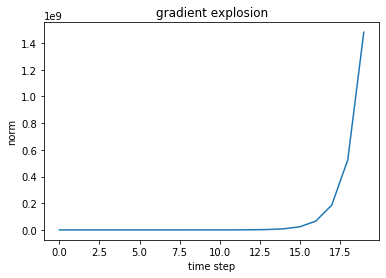

In [12]:
N = 2 #ミニバッチのサイズ
H = 3 #隠れ状態ベクトルの次元数
T = 20 #時系列データの長さ

dh = np.ones((N, H))
np.random.seed(0)
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh ** 2)) / N
    norm_list.append(norm)
plt.plot(np.arange(len(norm_list)), norm_list)
plt.title("gradient explosion")
plt.xlabel("time step")
plt.ylabel("norm")
plt.show()

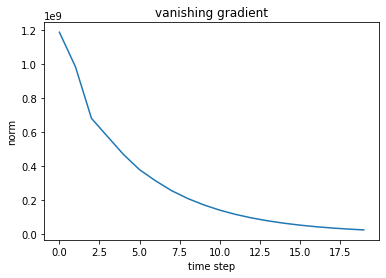

In [13]:
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh ** 2)) / N
    norm_list.append(norm)
plt.plot(np.arange(len(norm_list)), norm_list)
plt.title("vanishing gradient")
plt.xlabel("time step")
plt.ylabel("norm")
plt.show()

#RNNの勾配消失と勾配爆発に関しての論文:
"https://arxiv.org/abs/1211.5063"

### 勾配爆発の対策
* 勾配クリッピング

##### パラメータ
* g：ニューラルネットワークで使われる全てのパラメータの勾配を一つにまとめたもの
* 例：重みW1, W2→勾配dW1, dW2をまとめるみたいな感じ

\begin{align}
1. \quad & \hat{g} \leftarrow \frac{\partial \epsilon}{\partial \theta} \\
2. \quad & if \quad ||\hat{g}|| \geqq threshold \quad then \\
& \qquad \hat{g} \leftarrow \frac{threshold}{||\hat{g}||} \hat{g} \\
&   end if
\end{align}


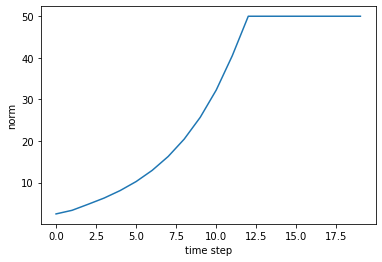

In [15]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0 #閾値：threshold

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate
            
clip_grads(grads, max_norm)

dh = np.ones((N, H))
 
np.random.seed(3)
 
Wh = np.random.randn(H, H)
 
norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    clip_grads(dh, max_norm=100)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xlabel("time step")
plt.ylabel("norm")
plt.show()

### 勾配消失とLSTM
* 防ぐ方法としてLSTMとGRU

#### LSTM
* LSTMには記憶セルcがある。

#### LSTMのゲートについて
* output：次の隠れ状態への出力をどれだけ通すかを指示。
$$o= \sigma(W_{x} x_t + W_{h} h_{(t-1)} + b)$$
* input:重み付けされた情報を新たに追加する。
$$i= \sigma(x_tW_x+h_{t-1}W_h+b)$$
* forget：記憶セルに対して何を忘れるかを明示的に指示する。
$$f= \sigma(x_tW_x+h_{t-1}W_h+b)$$
* tanhノード：新たに情報を追加する層。
$$g=\tanh(x_tW_x+h_{t-1}W_h+b)$$

#### LSTMの実装
* 記憶セル
$$c_t=f \odot c_{t-1}+g \odot i$$
* 隠れ状態ベクトル
$$h_t=o \odot \tanh(c_t)$$

In [16]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [17]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeors_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = np.sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)
        #逆伝播では勾配を結合する必要性がある（縦方向に連結する際はvstack()）
        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

In [18]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self,c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = cs.shape
        H = wh.shape[0]
        
        self.layer = []
        hs = np.empty((N, T, H), dtype="f")
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype="f")
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype="f")
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype="f")
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            self.dh = dh
            return dxs
        
    def set_stateful(self, h, c=None):
        self.h, self.c = h, c
        
    def reset_stateful(self):
        self.h, self.c = None, None

In [19]:
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()


Done
| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9996.42
| epoch 1 |  iter 21 / 1327 | time 4[s] | perplexity 2871.38
| epoch 1 |  iter 41 / 1327 | time 8[s] | perplexity 1209.32
| epoch 1 |  iter 61 / 1327 | time 12[s] | perplexity 964.57
| epoch 1 |  iter 81 / 1327 | time 16[s] | perplexity 789.06
| epoch 1 |  iter 101 / 1327 | time 20[s] | perplexity 652.31
| epoch 1 |  iter 121 / 1327 | time 24[s] | perplexity 629.49
| epoch 1 |  iter 141 / 1327 | time 27[s] | perplexity 603.03
| epoch 1 |  iter 161 / 1327 | time 31[s] | perplexity 567.91
| epoch 1 |  iter 181 / 1327 | time 35[s] | perplexity 594.95
| epoch 1 |  iter 201 / 1327 | time 39[s] | perplexity 504.66
| epoch 1 |  iter 221 / 1327 | time 43[s] | perplexity 494.37
| epoch 1 |  iter 241 / 1327 | time 48[s] | perplexity 446.97
| epoch 1 |  iter 261 / 1327 | time 53[s] | perplexity 448.87
| epoch 1 |  iter 281 / 1327 | time 57[s] | perplexity 439.02
| epoch 1 |  iter 301 / 1327 | time 62[s] | perplexity 393.53
| epoch 1

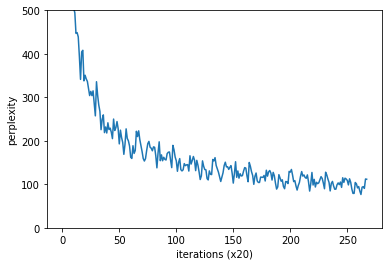

evaluating perplexity ...
234 / 235
test perplexity:  136.41248941276828


In [22]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.rnnlm import Rnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 35  # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()

### RNNLMのさらなる改善
* LSTMレイヤの多層化
* Dropoutによる過学習の抑制→多層化することでより豊かなモデルをさくせいできると同時に過学習が生じてしまう。→正則化など
* Drooutの際は時間軸方向に対して行うのではなく深さ方向に実装する。
* 重みの共有→パラメータが少なくなる
* 重み共有有効性についての根拠→https://arxiv.org/abs/1611.01462

In [23]:
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTMレイヤを2層利用し、各層にDropoutを使うモデル
     [1]で提案されたモデルをベースとし、weight tying[2][3]を利用

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()
